the retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.

etrieval models are often composed of two sub-models:

1. A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
2. A candidate model computing the candidate representation (an equally-sized vector) using the candidate features
The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.

cabdidate representation will be created from:
1. movie title
2. movie genre 
user representation will be created from:
1. user age.
2. user occupation.
3. user gender.
4. time as a contextual feature

# importing necessary libreries

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets


     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 462 kB 29.8 MB/s 
     |████████████████████████████████| 4.2 MB 4.7 MB/s 


In [ ]:
import os
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pprint

# Set up two virtual GPUs

# loading data from drive

In [ ]:
#movies=tf.data.experimental.load('/content/drive/MyDrive/datasets/movielens_movies')
ratings=tf.data.experimental.load('/content/drive/MyDrive/datasets/movielens_ratings')
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [ ]:
movie_data=ratings.map(lambda x:{
    'id':x['movie_id'],
    'title':x['movie_title'],
    'genre':fx['movie_genres'][0],

})





In [ ]:
for x in movie_data.take(1).as_numpy_iterator():
  pprint.pprint(x)
print('-------------------------------')


{'genre': 7.0, 'id': b'357', 'title': b"One Flew Over the Cuckoo's Nest (1975)"}
-------------------------------


# creating a vocabulary for movie title and user occupation

In [ ]:
movie_titles=movie_data.map(lambda x:x['title'])
unique_movie_titles=np.unique(np.concatenate(list(movie_titles.batch(1_000))))
movie_genres=movie_data.map(lambda x :x['genre'])
unique_movie_genres=np.unique(np.concatenate(list(movie_genres.batch(1_000))))

# spliting data to train and test 

In [ ]:
tf.random.set_seed(123)
shuffled=movie_data.shuffle(1_000,reshuffle_each_iteration=False)

train=shuffled.take(80_000)
test=shuffled.skip(80_000).take(10_000)

# building model
Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

#  creating seprate models

In [ ]:

# with strategy.scope():
embedding_dim=128
# genre model
genre_model=tf.keras.Sequential(
    [tf.keras.layers.IntegerLookup(vocabulary=unique_movie_genres),
    tf.keras.layers.Embedding(len(unique_movie_genres)+1,embedding_dim)
    ]
    )


# movie title model
movie_model=tf.keras.Sequential(
    [tf.keras.layers.StringLookup(vocabulary=unique_movie_titles),
    tf.keras.layers.Embedding(len(unique_movie_titles)+1,embedding_dim)
    ]
        )


# query tower

* user model

In [ ]:
# with strategy.scope():

class MovieModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.genre_model=genre_model
    self.movie_model=movie_model

  def call(self,inputs):
    out=tf.concat(
        [
        self.genre_model(inputs['genre']),
        self.movie_model(inputs['title']),
        ],axis=1
    )
    return out

In [ ]:
a=tf.constant([[1,23,3]])
b=tf.constant([[2,5,4,7]])
tf.concat([a,b],axis=1)

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[ 1, 23,  3,  2,  5,  4,  7]], dtype=int32)>

In [ ]:
# with strategy.scope():
class QueryTower(tf.keras.Model):
  def __init__(self,layers):
    super().__init__()
    self.movie_model=MovieModel()
    self.dense_model=tf.keras.Sequential()
    for layer in layers[:-1]:
      self.dense_model.add(tf.keras.layers.Dense(layer,activation='relu'))
    for layer in layers[-1:]:
      self.dense_model.add(tf.keras.layers.Dense(layer))
  def call(self,inputs):
    v=self.movie_model(inputs)
    return self.dense_model(v)


# candidate tower
* movie model

* candidate tower

In [ ]:
# with strategy.scope():
class CandidateTower(tf.keras.Model):
  def __init__(self,layers):
    super().__init__()
    self.movie_model=MovieModel()
    self.dense_model=tf.keras.Sequential()
    for layer in layers[:-1]:
      self.dense_model.add(tf.keras.layers.Dense(layer,activation='relu'))
    for layer in layers[-1:]:
      self.dense_model.add(tf.keras.layers.Dense(layer))
  def call(self,inputs):
    v=self.movie_model(inputs)
    return self.dense_model(v)

# Metrics
In our training data we have positive (user, user) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the tfrs.metrics.FactorizedTopK metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the movies dataset, converted into embeddings via our movie model:

# task
The task itself is a Keras layer that takes the query and candidate embeddings as arguments, and returns the computed loss: we'll use that to implement the model's training loop.

# the full model
We can now put it all together into a model. TFRS exposes a base model class (tfrs.models.Model) which streamlines building models: all we need to do is to set up the components in the __init__ method, and implement the compute_loss method, taking in the raw features and returning a loss value.

In [ ]:
# with strategy.scope():
class CombinedModels(tfrs.models.Model):
  def __init__(self,layers):
    super().__init__()
    self.query_tower=QueryTower(layers)
    self.candidate_tower=CandidateTower(layers)
    self.task=tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movie_data.batch(128).map(self.candidate_tower)
        )
    )
  def compute_loss(self, features,training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings=self.query_tower({
        'genre':features['genre'],
        'title':features['title'],

    })
    candidate_embeddings=self.candidate_tower({
        'genre':features['genre'],
        'title':features['title'],
    })
    return self.task(query_embeddings,candidate_embeddings,compute_metrics=not training)

# preparing data to train model

In [ ]:
cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(1024).cache()

# training 

In [ ]:
num_epochs = 10
# with strategy.scope():

model = CombinedModels([64,32,16])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

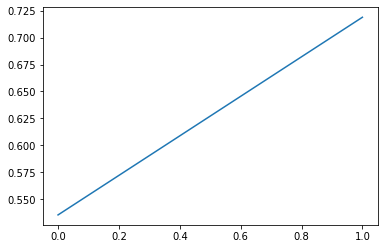

In [ ]:
import matplotlib.pyplot as plt

plt.plot(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])

In [ ]:
accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.72.


# making prediction

In [ ]:
d=[i for i in train.batch(1).take(20).cache()]


In [ ]:
top_k=10000
index=tfrs.layers.factorized_top_k.BruteForce(model.query_tower,k=top_k)
'''index.index_from_dataset(
    tf.data.Dataset.zip((candidate identifiers,
                         candidate embeddings)))
)'''
index.index_from_dataset(
    tf.data.Dataset.zip((movie_data.map(lambda x : x['id']).batch(100),
                         movie_data.batch(100).map(model.candidate_tower)))
)


# utility functions

In [ ]:
def output_cleaner(outputs):
  (unique, counts) = np.unique(outputs.numpy()[0], return_counts=True)
  ziped_file=zip(unique,counts)
  output_array=outputs.numpy()[0]
  for uniques in unique:
    to_be_deleted=np.where(output_array==uniques)[0]
    output_array=np.delete(output_array,to_be_deleted[1:])
  dictionary=dict(ziped_file)
  ys =[]
  
  
  for i,x in enumerate(output_array):
    ys.append((f'{i+1}th movie ', x))


  return ys
      


In [ ]:
def movie_feature_extractor(id_wanted):
  for j in movie_data.batch(1):
    i=0
    if j['id'].numpy()[0]==id_wanted:
      i+=1
      if i==1:
        print('movie features: \n')
        print('title: ',j['title'].numpy()[0] )
        print('genre ',j['genre'].numpy()[0])
        print('id ',j['id'].numpy()[0],'\n\n')
        break




In [ ]:
def n_first_recommended_movies(results,n):
  for i in out[:n]:
    movie_feature_extractor(i[1])
    print('-------------------------')


In [ ]:
def n_last_recommended_movies(results,n):
  for i in out[-n:]:
    movie_feature_extractor(i[1])
    print('-------------------------')


# print predictions

In [ ]:
print(f"{top_k} movies similar to movie:{d[1]['id'].numpy()[0]} with below features \n\n")
movie_feature_extractor(d[1]['id'].numpy()[0])
extra,recommes=index(d[1])
out=output_cleaner(recommes)


10000 movies similar to movie:b'568' with below features 


movie features: 

title:  b'Speed (1994)'
genre  0.0
id  b'568' 


